In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_theme(style='darkgrid', palette='rainbow')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


# Converting the Quarters into Years

In [3]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


# Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)

In [4]:
# Converting into datetime formate as the index was not in correct formate.
df['Date'] = (pd.to_datetime(df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


# Extracting the Quarters and putting in column

In [5]:
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


# Creating Dummy Variables for Quarters Variable

In [6]:
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


# Dropping all the unnecessary column

In [7]:
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


# Making the Date as DateTime index for the Dataframe

In [8]:
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [9]:
df1

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0
1987-04-01,2104.411995,Q2,0,1,0,0
1987-07-01,2014.362999,Q3,0,0,1,0
1987-10-01,1991.746998,Q4,0,0,0,1
1988-01-01,1869.049999,Q1,1,0,0,0


In [10]:
df1.describe()

,Sales,Q1,Q2,Q3,Q4
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,2994.353308,0.261905,0.261905,0.238095,0.238095
std,977.930896,0.445001,0.445001,0.431081,0.431081
min,1547.818996,0.000000,0.000000,0.000000,0.000000
25%,2159.714247,0.000000,0.000000,0.000000,0.000000
50%,2782.376999,0.000000,0.000000,0.000000,0.000000
75%,3609.250000,0.750000,0.750000,0.000000,0.000000
max,5253.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 1986-01-01 to 1996-04-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     42 non-null     float64
 1   Quarters  42 non-null     object 
 2   Q1        42 non-null     uint8  
 3   Q2        42 non-null     uint8  
 4   Q3        42 non-null     uint8  
 5   Q4        42 non-null     uint8  
dtypes: float64(1), object(1), uint8(4)
memory usage: 1.1+ KB


In [12]:
# Upsampling

In [13]:
upsampled = df1.resample('M').mean()
upsampled

,Sales,Q1,Q2,Q3,Q4
Date,,,,,
1986-01-31,1734.827000,1.0,0.0,0.0,0.0
1986-02-28,NaN,NaN,NaN,NaN,NaN
1986-03-31,NaN,NaN,NaN,NaN,NaN
1986-04-30,2244.960999,0.0,1.0,0.0,0.0
1986-05-31,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1995-12-31,NaN,NaN,NaN,NaN,NaN
1996-01-31,4194.000000,1.0,0.0,0.0,0.0
1996-02-29,NaN,NaN,NaN,NaN,NaN


In [14]:
# Interpolate the missing values

In [15]:
interpolated = upsampled.interpolate()
interpolated.head(10)

,Sales,Q1,Q2,Q3,Q4
Date,,,,,
1986-01-31,1734.827000,1.000000,0.000000,0.000000,0.000000
1986-02-28,1904.871666,0.666667,0.333333,0.000000,0.000000
1986-03-31,2074.916332,0.333333,0.666667,0.000000,0.000000
1986-04-30,2244.960999,0.000000,1.000000,0.000000,0.000000
1986-05-31,2341.242330,0.000000,0.666667,0.333333,0.000000
1986-06-30,2437.523661,0.000000,0.333333,0.666667,0.000000
1986-07-31,2533.804993,0.000000,0.000000,1.000000,0.000000
1986-08-31,2407.524328,0.000000,0.000000,0.666667,0.333333
1986-09-30,2281.243663,0.000000,0.000000,0.333333,0.666667


<Axes: xlabel='Date'>

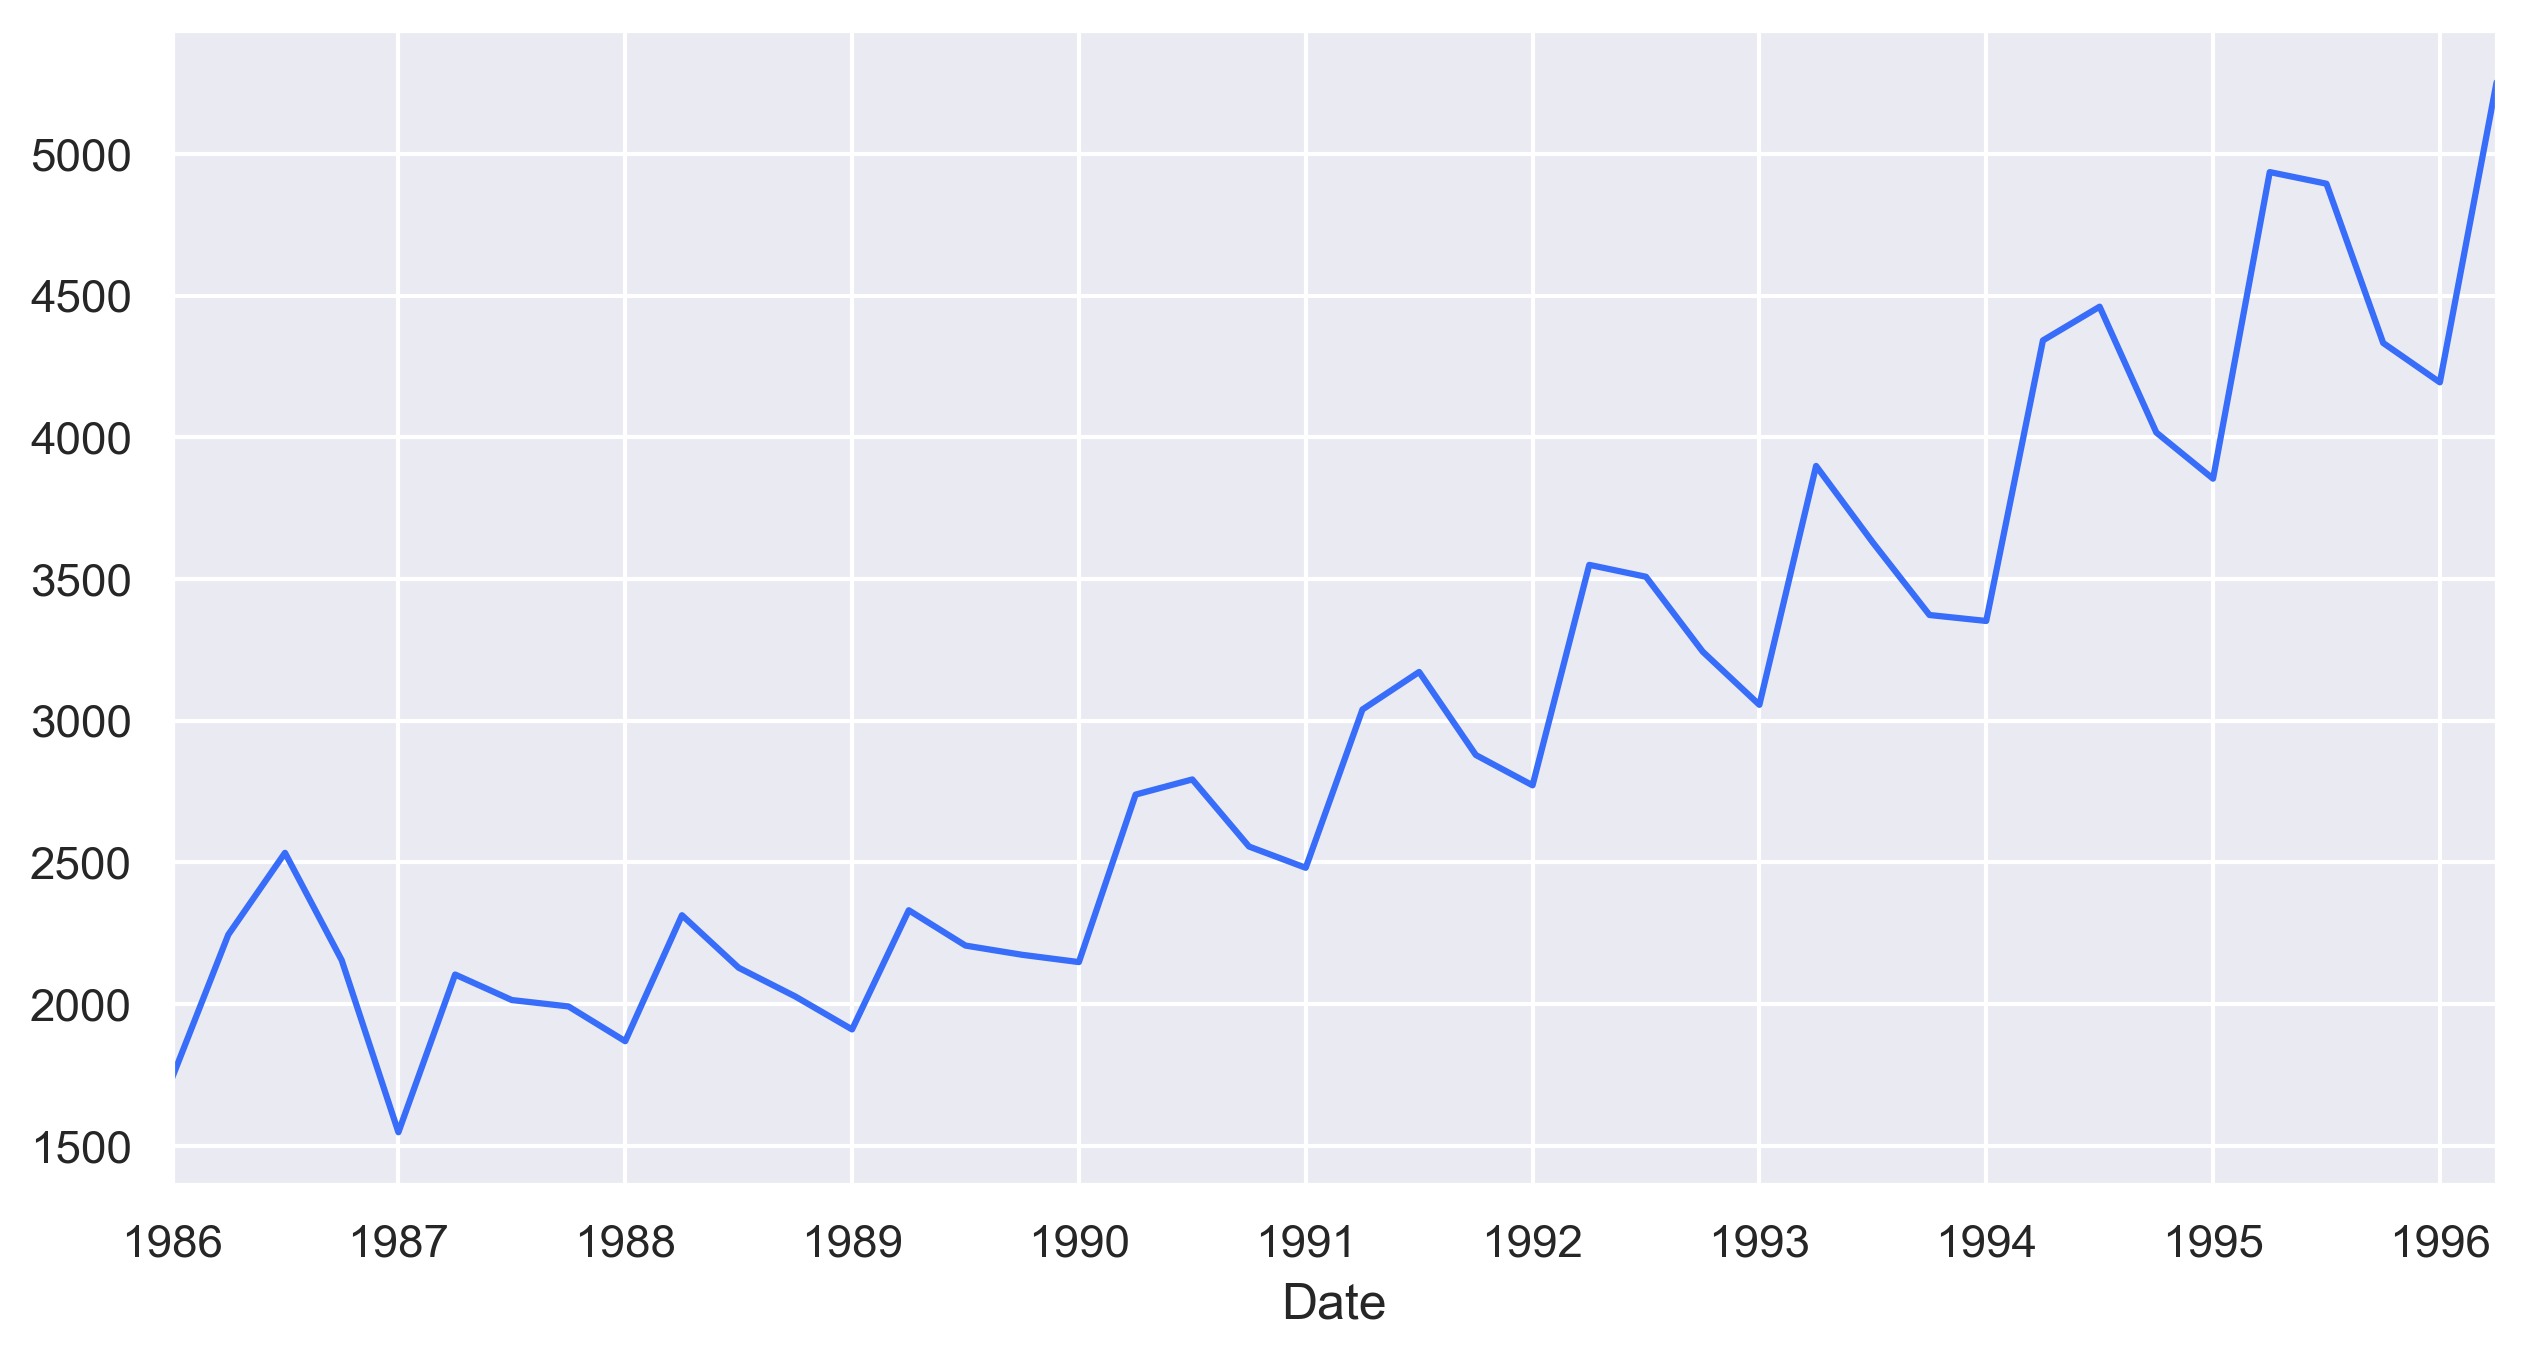

In [16]:
interpolated['Sales'].plot()

<Axes: xlabel='Date'>

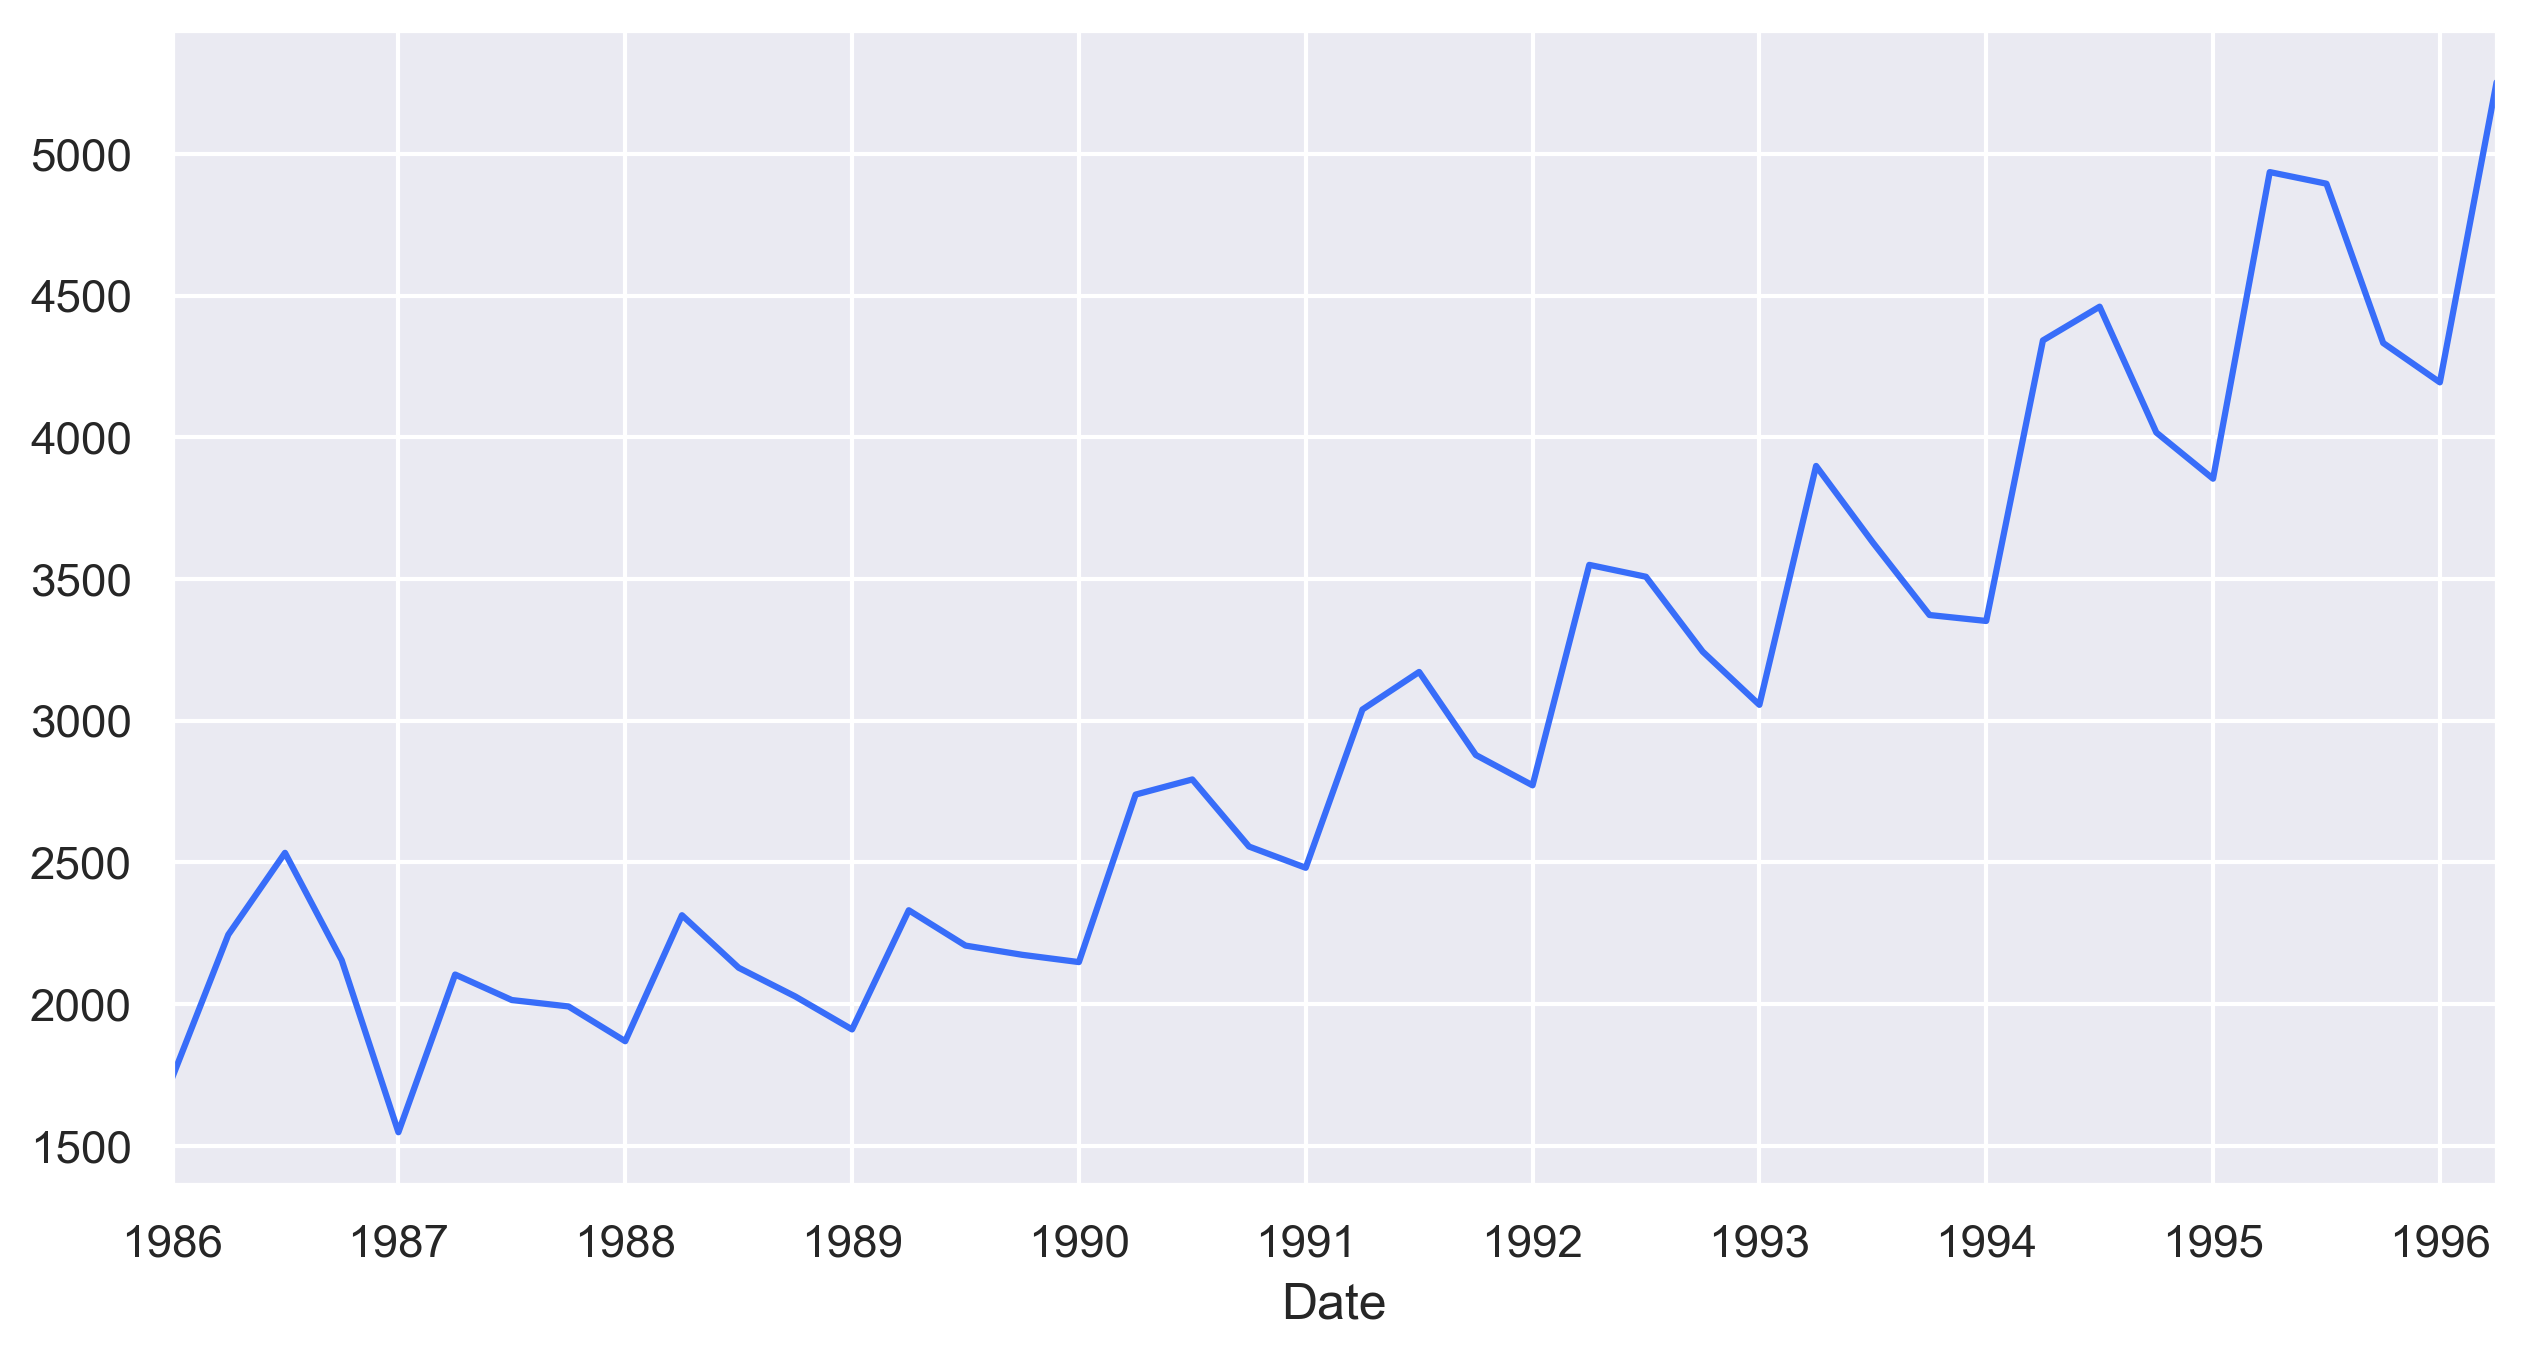

In [17]:
df1['Sales'].plot()

In [18]:
interpolated["t"] =interpolated.index.strftime("%m")
interpolated

,Sales,Q1,Q2,Q3,Q4,t
Date,,,,,,
1986-01-31,1734.827000,1.000000,0.000000,0.000000,0.000000,01
1986-02-28,1904.871666,0.666667,0.333333,0.000000,0.000000,02
1986-03-31,2074.916332,0.333333,0.666667,0.000000,0.000000,03
1986-04-30,2244.960999,0.000000,1.000000,0.000000,0.000000,04
1986-05-31,2341.242330,0.000000,0.666667,0.333333,0.000000,05
...,...,...,...,...,...,...
1995-12-31,4240.333333,0.666667,0.000000,0.000000,0.333333,12
1996-01-31,4194.000000,1.000000,0.000000,0.000000,0.000000,01
1996-02-29,4547.000000,0.666667,0.333333,0.000000,0.000000,02


In [19]:
interpolated['log_of_Sales']=np.log(interpolated['Sales'])
interpolated

,Sales,Q1,Q2,Q3,Q4,t,log_of_Sales
Date,,,,,,,
1986-01-31,1734.827000,1.000000,0.000000,0.000000,0.000000,01,7.458663
1986-02-28,1904.871666,0.666667,0.333333,0.000000,0.000000,02,7.552170
1986-03-31,2074.916332,0.333333,0.666667,0.000000,0.000000,03,7.637676
1986-04-30,2244.960999,0.000000,1.000000,0.000000,0.000000,04,7.716443
1986-05-31,2341.242330,0.000000,0.666667,0.333333,0.000000,05,7.758437
...,...,...,...,...,...,...,...
1995-12-31,4240.333333,0.666667,0.000000,0.000000,0.333333,12,8.352397
1996-01-31,4194.000000,1.000000,0.000000,0.000000,0.000000,01,8.341410
1996-02-29,4547.000000,0.666667,0.333333,0.000000,0.000000,02,8.422223


In [20]:
interpolated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 1986-01-31 to 1996-04-30
Freq: M
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sales         124 non-null    float64
 1   Q1            124 non-null    float64
 2   Q2            124 non-null    float64
 3   Q3            124 non-null    float64
 4   Q4            124 non-null    float64
 5   t             124 non-null    object 
 6   log_of_Sales  124 non-null    float64
dtypes: float64(6), object(1)
memory usage: 7.8+ KB


In [21]:
interpolated['t'] = pd.to_numeric(interpolated['t'], errors='coerce')
interpolated['square_of_t']=np.square(interpolated['t'])
interpolated

,Sales,Q1,Q2,Q3,Q4,t,log_of_Sales,square_of_t
Date,,,,,,,,
1986-01-31,1734.827000,1.000000,0.000000,0.000000,0.000000,1,7.458663,1
1986-02-28,1904.871666,0.666667,0.333333,0.000000,0.000000,2,7.552170,4
1986-03-31,2074.916332,0.333333,0.666667,0.000000,0.000000,3,7.637676,9
1986-04-30,2244.960999,0.000000,1.000000,0.000000,0.000000,4,7.716443,16
1986-05-31,2341.242330,0.000000,0.666667,0.333333,0.000000,5,7.758437,25
...,...,...,...,...,...,...,...,...
1995-12-31,4240.333333,0.666667,0.000000,0.000000,0.333333,12,8.352397,144
1996-01-31,4194.000000,1.000000,0.000000,0.000000,0.000000,1,8.341410,1
1996-02-29,4547.000000,0.666667,0.333333,0.000000,0.000000,2,8.422223,4


In [22]:
interpolated['t_copy'] = interpolated['t']
interpolated = pd.get_dummies(interpolated, columns=['t'])
interpolated

,Sales,Q1,Q2,Q3,Q4,log_of_Sales,square_of_t,t_copy,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12
Date,,,,,,,,,,,,,,,,,,,,
1986-01-31,1734.827000,1.000000,0.000000,0.000000,0.000000,7.458663,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1986-02-28,1904.871666,0.666667,0.333333,0.000000,0.000000,7.552170,4,2,0,1,0,0,0,0,0,0,0,0,0,0
1986-03-31,2074.916332,0.333333,0.666667,0.000000,0.000000,7.637676,9,3,0,0,1,0,0,0,0,0,0,0,0,0
1986-04-30,2244.960999,0.000000,1.000000,0.000000,0.000000,7.716443,16,4,0,0,0,1,0,0,0,0,0,0,0,0
1986-05-31,2341.242330,0.000000,0.666667,0.333333,0.000000,7.758437,25,5,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-12-31,4240.333333,0.666667,0.000000,0.000000,0.333333,8.352397,144,12,0,0,0,0,0,0,0,0,0,0,0,1
1996-01-31,4194.000000,1.000000,0.000000,0.000000,0.000000,8.341410,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1996-02-29,4547.000000,0.666667,0.333333,0.000000,0.000000,8.422223,4,2,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
interpolated = interpolated.rename(columns={'t_copy': 't'})
interpolated

,Sales,Q1,Q2,Q3,Q4,log_of_Sales,square_of_t,t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12
Date,,,,,,,,,,,,,,,,,,,,
1986-01-31,1734.827000,1.000000,0.000000,0.000000,0.000000,7.458663,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1986-02-28,1904.871666,0.666667,0.333333,0.000000,0.000000,7.552170,4,2,0,1,0,0,0,0,0,0,0,0,0,0
1986-03-31,2074.916332,0.333333,0.666667,0.000000,0.000000,7.637676,9,3,0,0,1,0,0,0,0,0,0,0,0,0
1986-04-30,2244.960999,0.000000,1.000000,0.000000,0.000000,7.716443,16,4,0,0,0,1,0,0,0,0,0,0,0,0
1986-05-31,2341.242330,0.000000,0.666667,0.333333,0.000000,7.758437,25,5,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-12-31,4240.333333,0.666667,0.000000,0.000000,0.333333,8.352397,144,12,0,0,0,0,0,0,0,0,0,0,0,1
1996-01-31,4194.000000,1.000000,0.000000,0.000000,0.000000,8.341410,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1996-02-29,4547.000000,0.666667,0.333333,0.000000,0.000000,8.422223,4,2,0,1,0,0,0,0,0,0,0,0,0,0


In [24]:
interpolated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 1986-01-31 to 1996-04-30
Freq: M
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sales         124 non-null    float64
 1   Q1            124 non-null    float64
 2   Q2            124 non-null    float64
 3   Q3            124 non-null    float64
 4   Q4            124 non-null    float64
 5   log_of_Sales  124 non-null    float64
 6   square_of_t   124 non-null    int64  
 7   t             124 non-null    int64  
 8   t_1           124 non-null    uint8  
 9   t_2           124 non-null    uint8  
 10  t_3           124 non-null    uint8  
 11  t_4           124 non-null    uint8  
 12  t_5           124 non-null    uint8  
 13  t_6           124 non-null    uint8  
 14  t_7           124 non-null    uint8  
 15  t_8           124 non-null    uint8  
 16  t_9           124 non-null    uint8  
 17  t_10          124 non-null    uint8  
 18  t_1

<Axes: xlabel='Date', ylabel='Sales'>

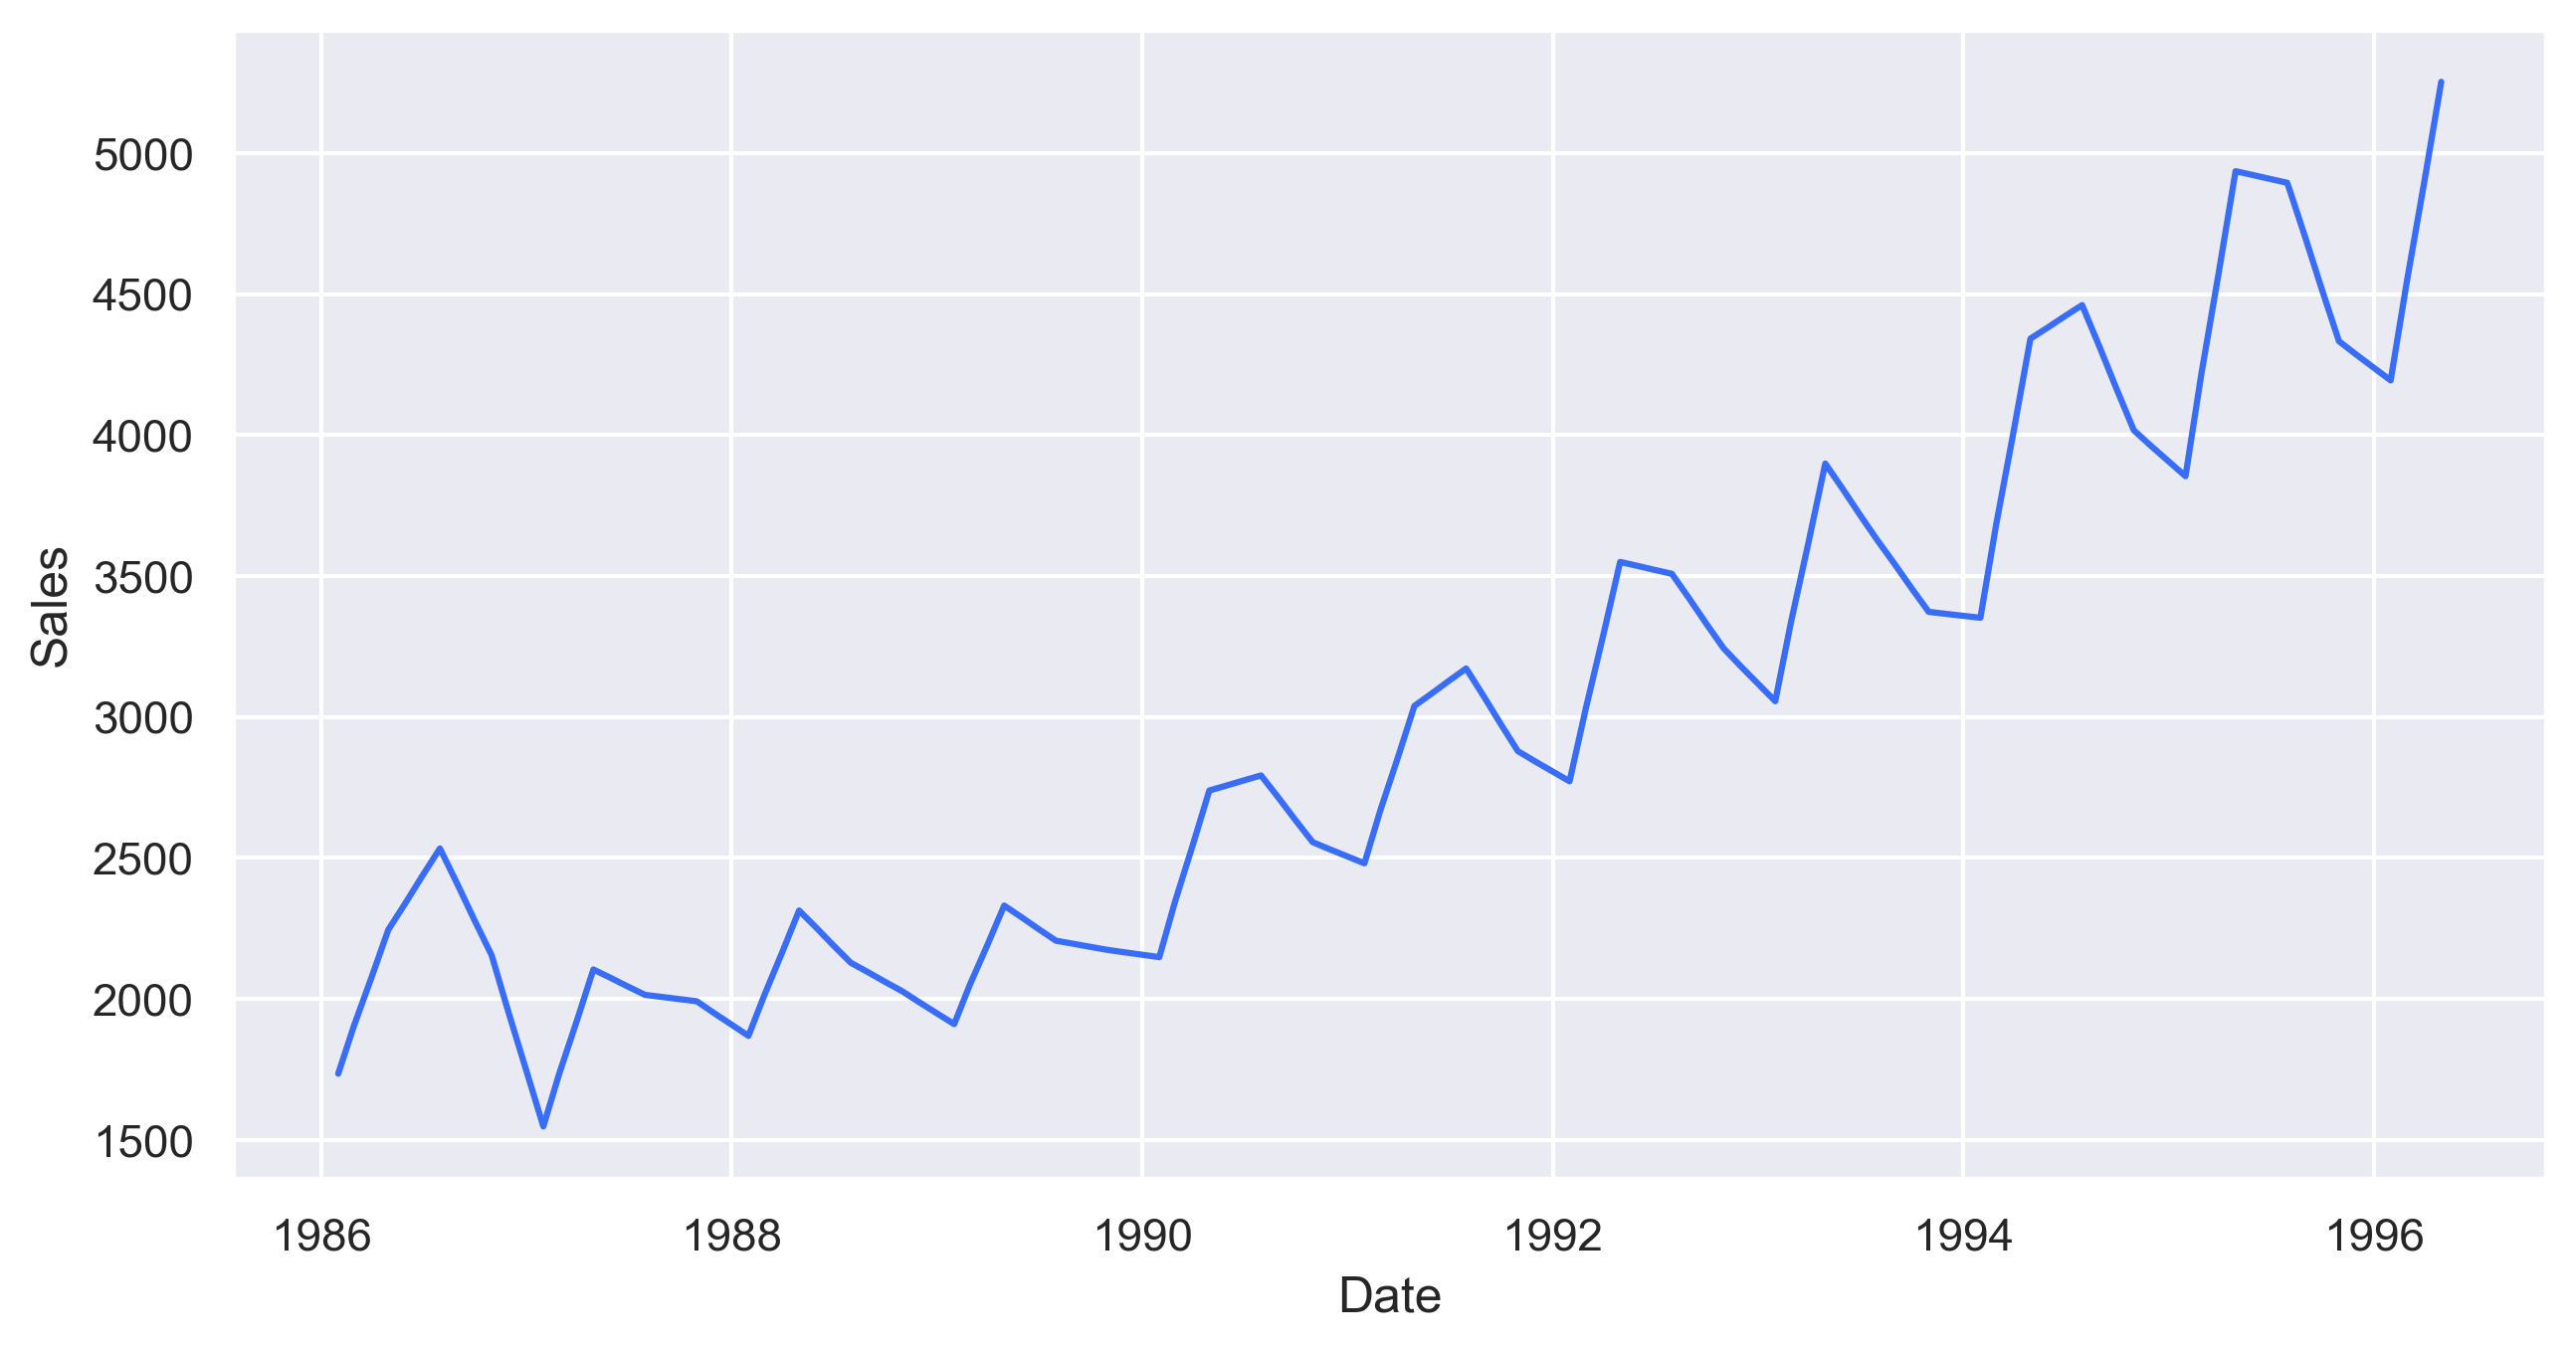

In [25]:
sns.lineplot(interpolated['Sales'])

In [26]:
# Splitting data

In [27]:
Train = interpolated.head(100)
Test = interpolated.tail(24)

In [28]:
Test

,Sales,Q1,Q2,Q3,Q4,log_of_Sales,square_of_t,t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12
Date,,,,,,,,,,,,,,,,,,,,
1994-05-31,4381.666667,0.000000,0.666667,0.333333,0.000000,8.385184,25,5,0,0,0,0,1,0,0,0,0,0,0,0
1994-06-30,4421.333333,0.000000,0.333333,0.666667,0.000000,8.394197,36,6,0,0,0,0,0,1,0,0,0,0,0,0
1994-07-31,4461.000000,0.000000,0.000000,1.000000,0.000000,8.403128,49,7,0,0,0,0,0,0,1,0,0,0,0,0
1994-08-31,4313.000000,0.000000,0.000000,0.666667,0.333333,8.369389,64,8,0,0,0,0,0,0,0,1,0,0,0,0
1994-09-30,4165.000000,0.000000,0.000000,0.333333,0.666667,8.334472,81,9,0,0,0,0,0,0,0,0,1,0,0,0
1994-10-31,4017.000000,0.000000,0.000000,0.000000,1.000000,8.298291,100,10,0,0,0,0,0,0,0,0,0,1,0,0
1994-11-30,3962.666667,0.333333,0.000000,0.000000,0.666667,8.284672,121,11,0,0,0,0,0,0,0,0,0,0,1,0
1994-12-31,3908.333333,0.666667,0.000000,0.000000,0.333333,8.270866,144,12,0,0,0,0,0,0,0,0,0,0,0,1
1995-01-31,3854.000000,1.000000,0.000000,0.000000,0.000000,8.256867,1,1,1,0,0,0,0,0,0,0,0,0,0,0


In [29]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(mean_squared_error(Test['Sales'], pred_linear))
rmse_linear

1857.0047532823983

In [30]:
#Exponential

Exp = smf.ols('log_of_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(mean_squared_error(Test['Sales'], pred_Exp))
rmse_Exp

4462.01276825872

In [31]:
#Quadratic 

Quad = smf.ols('Sales~t+square_of_t',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","square_of_t"]]))
rmse_Quad = np.sqrt(mean_squared_error(Test['Sales'],pred_Quad))
rmse_Quad

1842.2013105505284

In [32]:
#Additive seasonality 
add_sea = smf.ols('Sales~t_1+t_2+t_3+t_4+t_5+t_6+t_7+t_8+t_9+t_10+t_11',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['t_1','t_2','t_3','t_4','t_5','t_6','t_7','t_8','t_9','t_10','t_11']]))
rmse_add_sea = np.sqrt(mean_squared_error(Test['Sales'], pred_add_sea))
rmse_add_sea

1837.787972348381

In [33]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+square_of_t+t_1+t_2+t_3+t_4+t_5+t_6+t_7+t_8+t_9+t_10+t_11',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['t_1','t_2','t_3','t_4','t_5','t_6','t_7','t_8','t_9','t_10','t_11','t','square_of_t']]))
rmse_add_sea_quad = np.sqrt(mean_squared_error(Test['Sales'], pred_add_sea_quad))
rmse_add_sea_quad

1837.7879723487015

In [34]:
#Multiplicative Seasonality 

Mul_Add_sea = smf.ols('log_of_Sales~t+t_1+t_2+t_3+t_4+t_5+t_6+t_7+t_8+t_9+t_10+t_11',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(mean_squared_error(Test['Sales'], pred_Mult_add_sea))
rmse_Mult_add_sea 

4462.008204384481

In [35]:
#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
3,rmse_add_sea,1837.787972
4,rmse_add_sea_quad,1837.787972
2,rmse_Quad,1842.201311
0,rmse_linear,1857.004753
5,rmse_Mult_sea,4462.008204
1,rmse_Exp,4462.012768


In [36]:
# Moving Average

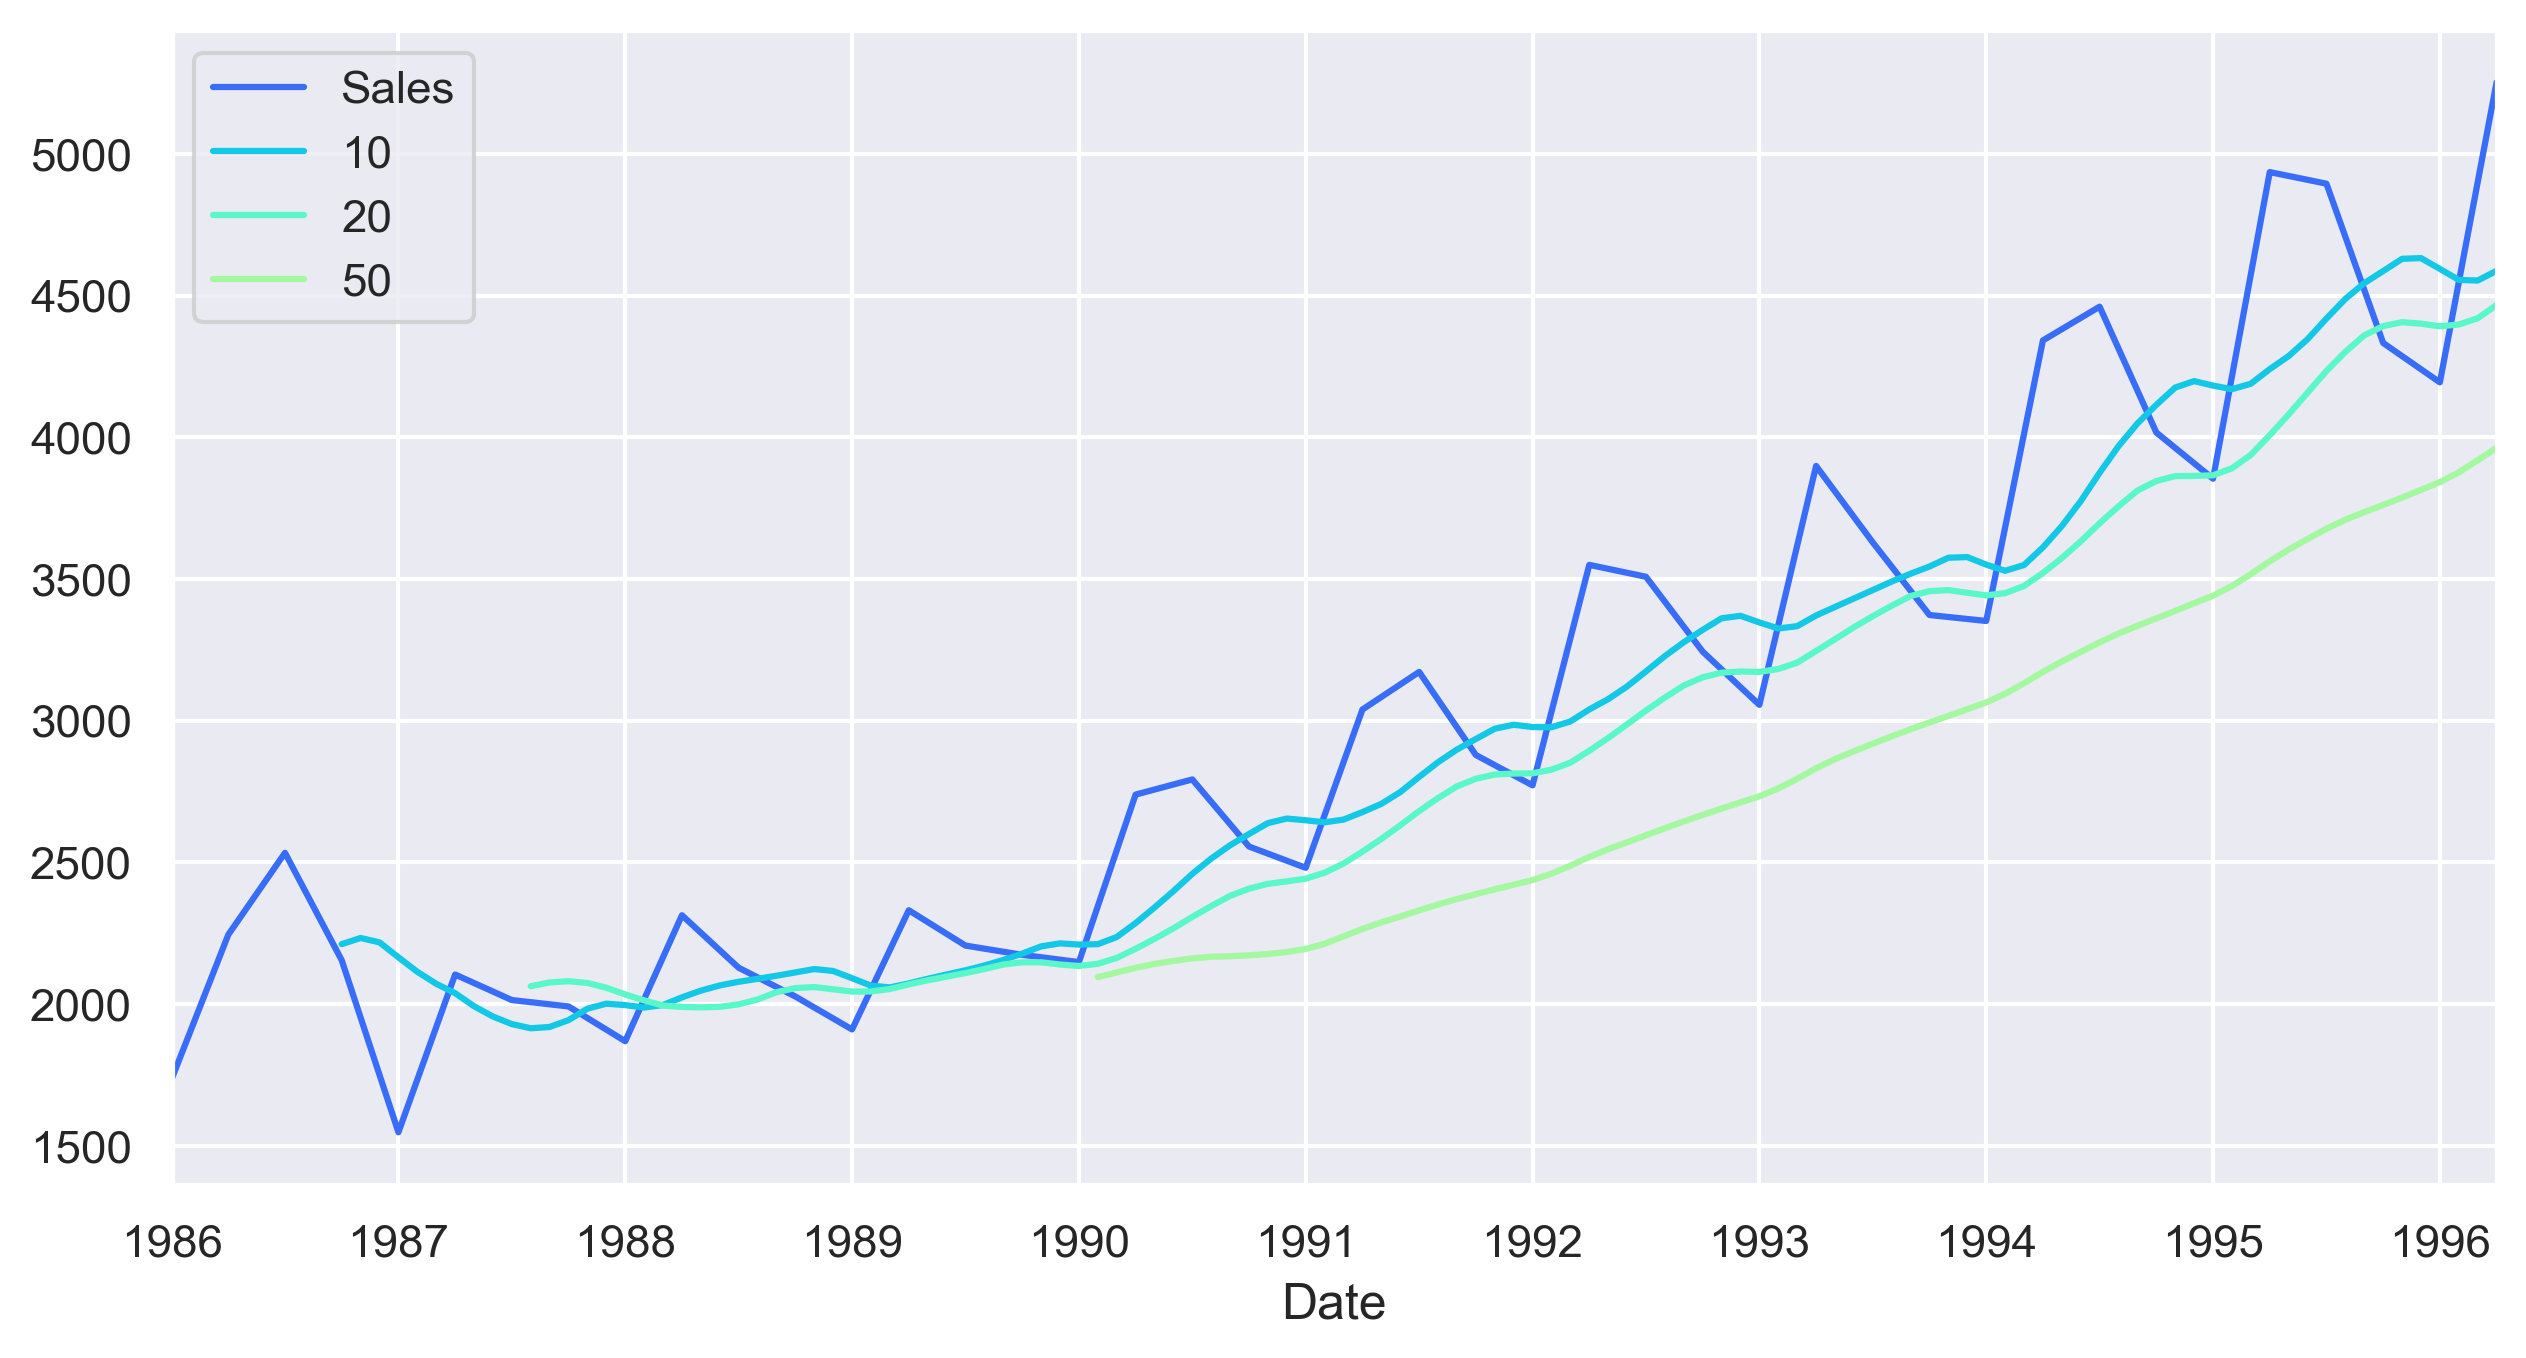

In [37]:
interpolated['Sales'].plot()
interpolated['Sales'].rolling(10).mean().plot(label = '10')
interpolated['Sales'].rolling(20).mean().plot(label = '20')
interpolated['Sales'].rolling(50).mean().plot(label = '50')
plt.legend()

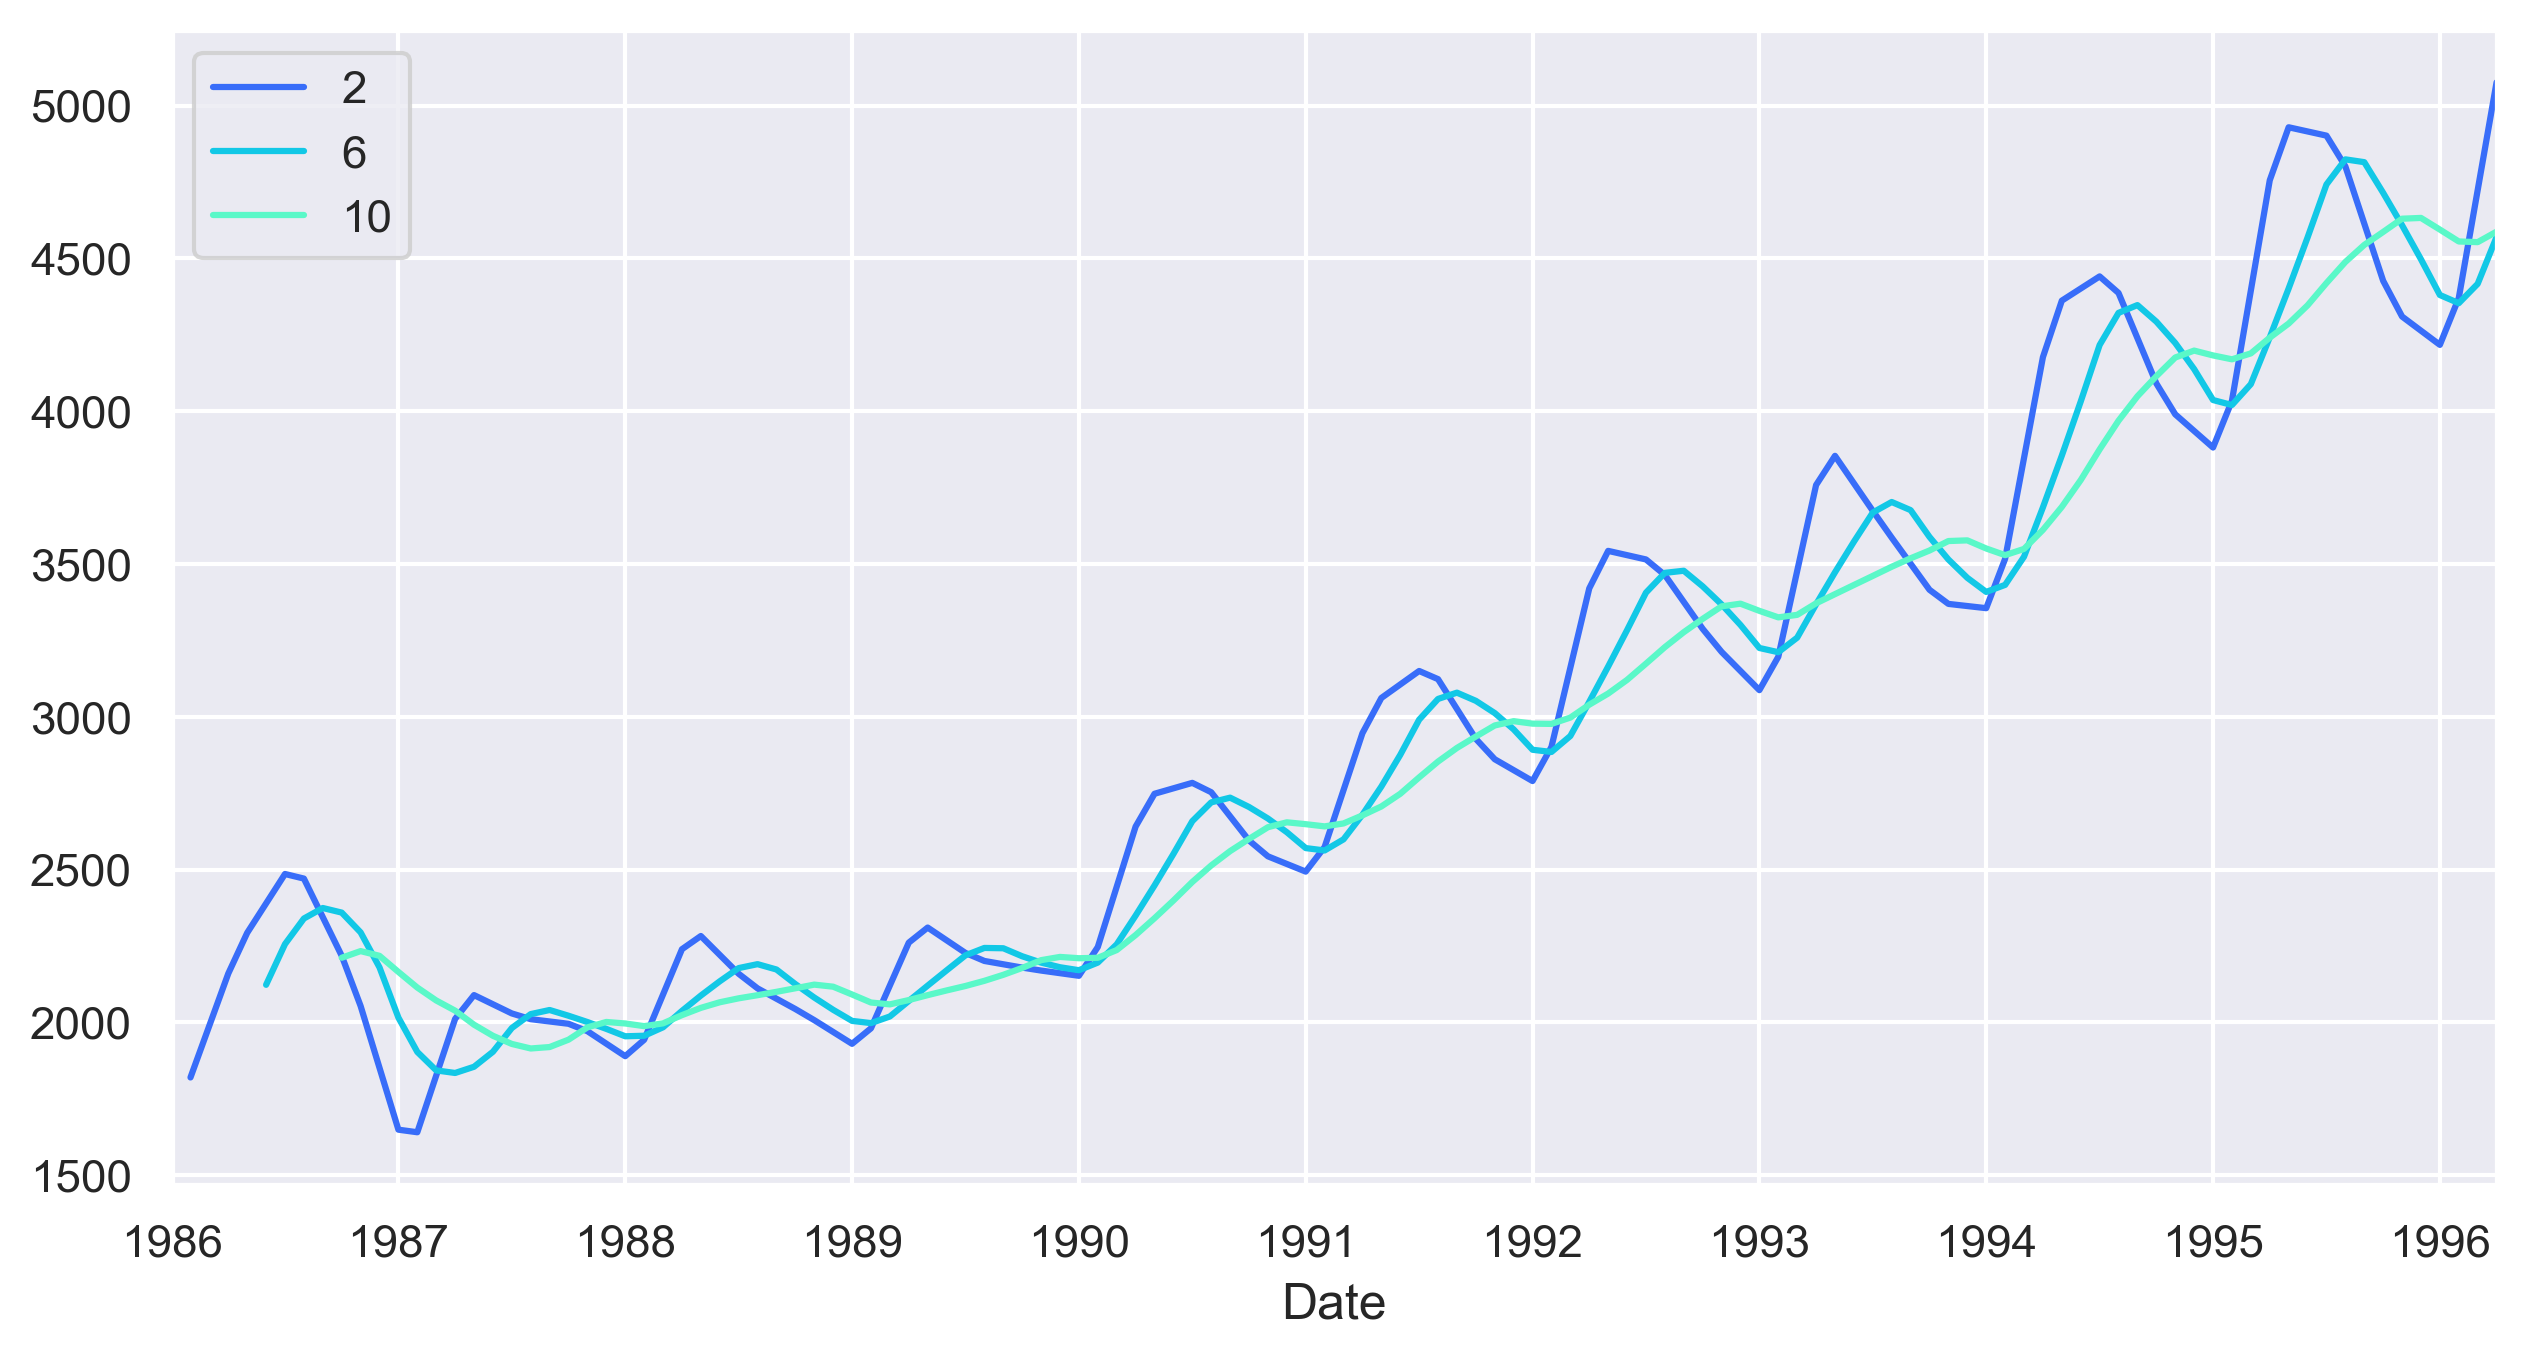

In [38]:
for i in range(2,12,4):
    interpolated['Sales'].rolling(i).mean().plot(label = str(i))
    plt.legend()

In [39]:
# Weighted Moving Average

In [40]:
weights = np.array([0.1, 0.2, 0.3,0.4])
interpolated['WMA'] = interpolated['Sales'].rolling(4).apply(lambda x: np.sum(weights*x))
interpolated

,Sales,Q1,Q2,Q3,Q4,log_of_Sales,square_of_t,t,t_1,t_2,...,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,WMA
Date,,,,,,,,,,,,,,,,,,,,,
1986-01-31,1734.827000,1.000000,0.000000,0.000000,0.000000,7.458663,1,1,1,0,...,0,0,0,0,0,0,0,0,0,NaN
1986-02-28,1904.871666,0.666667,0.333333,0.000000,0.000000,7.552170,4,2,0,1,...,0,0,0,0,0,0,0,0,0,NaN
1986-03-31,2074.916332,0.333333,0.666667,0.000000,0.000000,7.637676,9,3,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1986-04-30,2244.960999,0.000000,1.000000,0.000000,0.000000,7.716443,16,4,0,0,...,1,0,0,0,0,0,0,0,0,2074.916332
1986-05-31,2341.242330,0.000000,0.666667,0.333333,0.000000,7.758437,25,5,0,0,...,0,1,0,0,0,0,0,0,0,2215.455665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-12-31,4240.333333,0.666667,0.000000,0.000000,0.333333,8.352397,144,12,0,0,...,0,0,0,0,0,0,0,0,1,4300.766667
1996-01-31,4194.000000,1.000000,0.000000,0.000000,0.000000,8.341410,1,1,1,0,...,0,0,0,0,0,0,0,0,0,4240.333333
1996-02-29,4547.000000,0.666667,0.333333,0.000000,0.000000,8.422223,4,2,0,1,...,0,0,0,0,0,0,0,0,0,4353.733333


<Axes: xlabel='Date'>

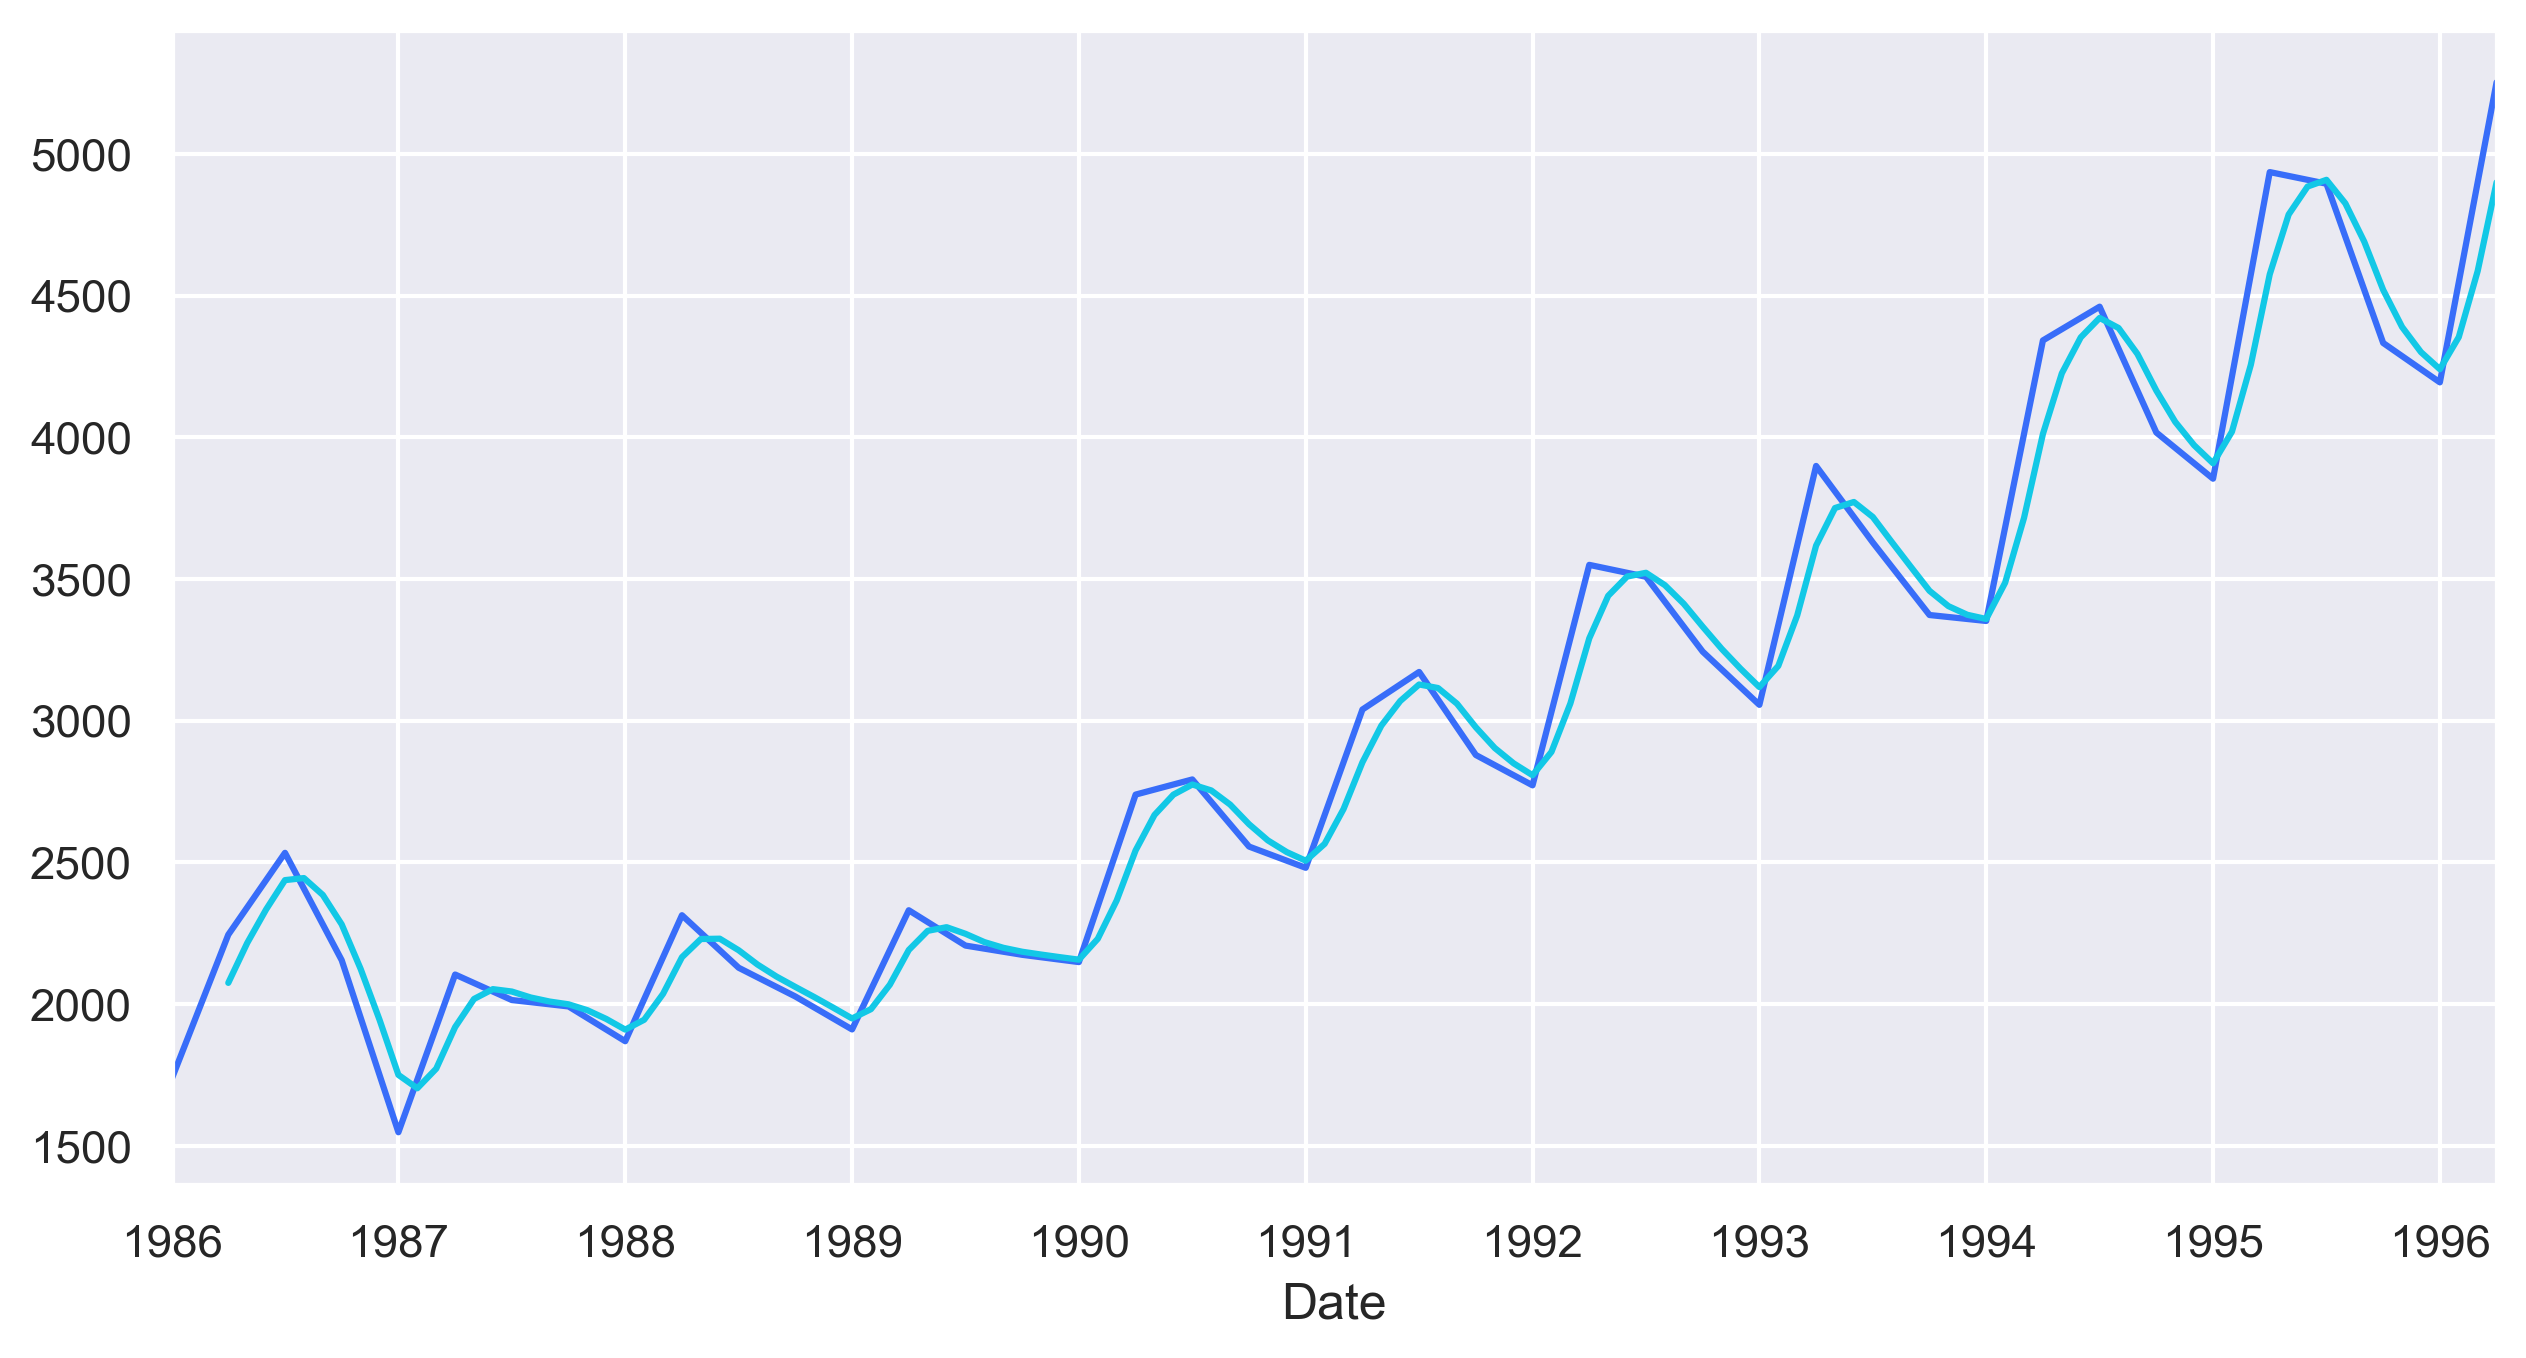

In [41]:
interpolated['Sales'].plot()
interpolated['WMA'].plot()

In [42]:
# Arima Model

In [43]:
df1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


# Dropping all the unnecessary column

In [44]:
df=df1.drop(columns=['Quarters','Q1','Q2','Q3','Q4'])

In [45]:
df

,Sales
Date,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993
1986-10-01,2154.962997
1987-01-01,1547.818996
1987-04-01,2104.411995
1987-07-01,2014.362999
1987-10-01,1991.746998
1988-01-01,1869.049999


In [46]:
# Check stationarity of the data

<Axes: xlabel='Date'>

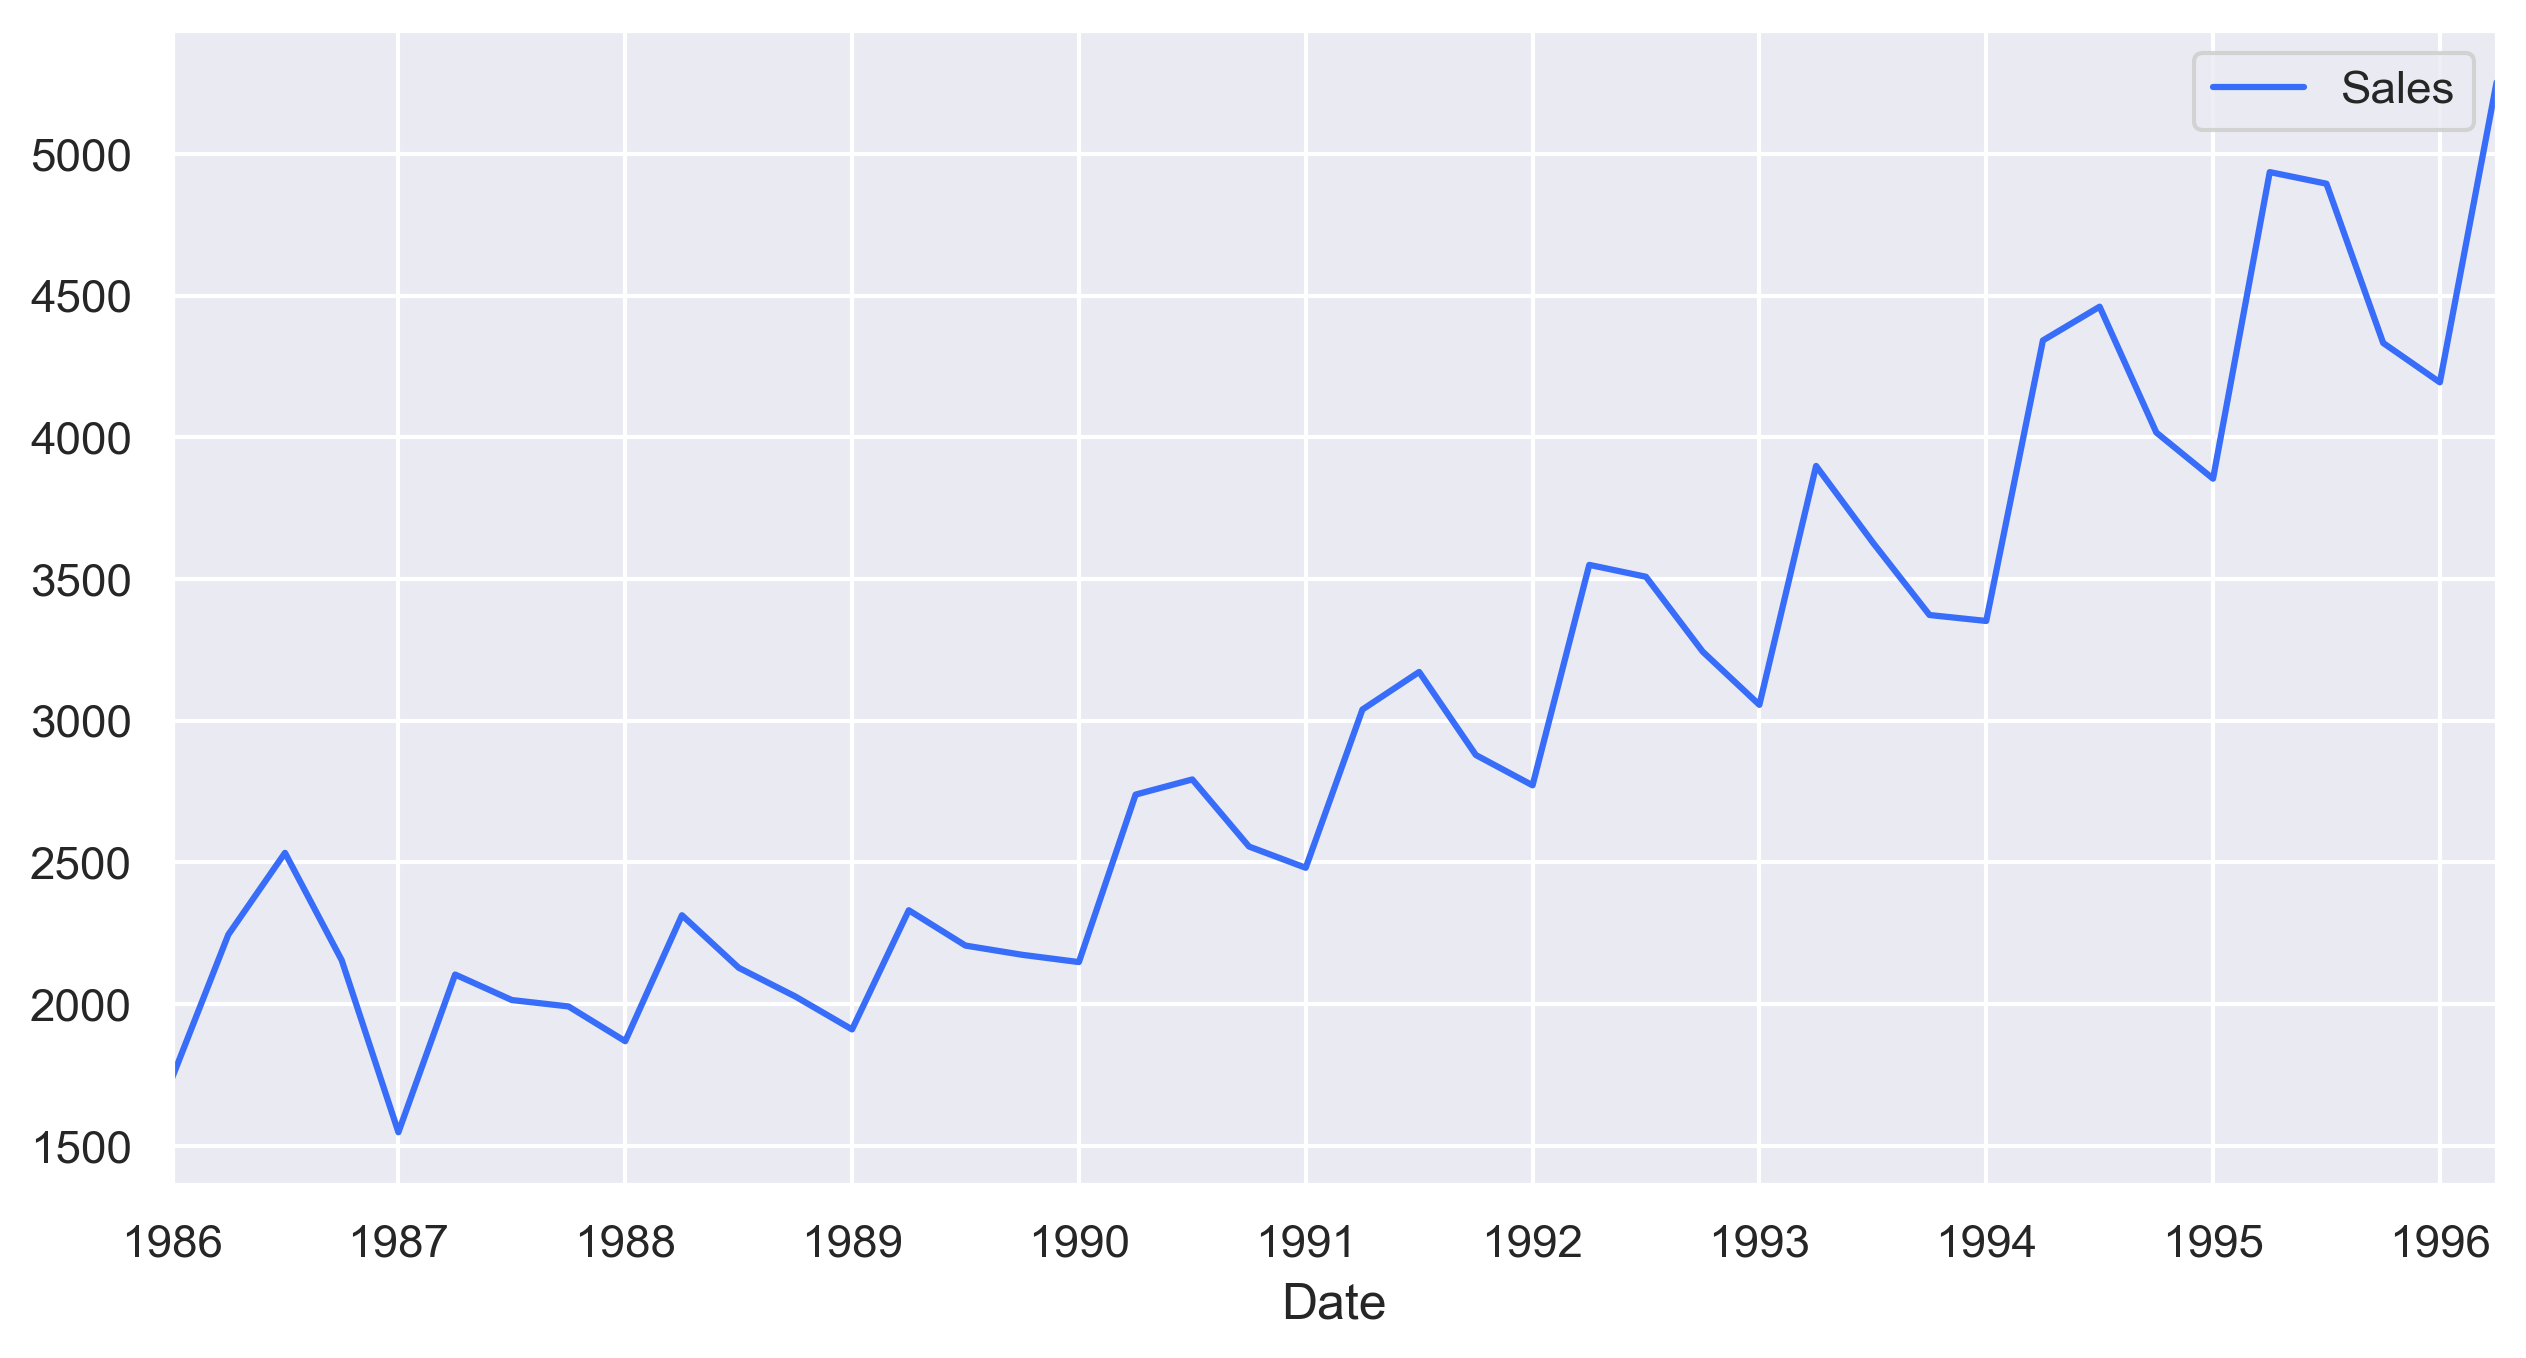

In [47]:
df.plot()

In [48]:
adfuller(df['Sales'])[1].round(5)

0.99666

In [ ]:
Null hypothesis: Data is Non stationary

Alternate Hypothesis: Data is Stationary

- If p< 0.05 ; Data is stationary

- if p>0.05; Data is not stationary

According the p-value, the dataset is non stationary as the p value is more than alpha value.

Arima model building.

- ARIMA is composed of 3 terms(Auto-Regression(p) + Integrated(d) + Moving-Average(q))
- First, we need to find out the order of arima model.

In [ ]:
#find out order of arima

In [49]:
order = auto_arima(df['Sales'])

In [50]:
order#(p,d,q)=>p=PACF,d=differencing method value,q=ACF,

ARIMA(order=(4, 1, 0), scoring_args={}, suppress_warnings=True)

In [51]:
df.shape

(42, 1)

In [52]:
#Split the data
train = df.head(34)
test = df.tail(8)

In [53]:
train.shape

(34, 1)

In [54]:
test.shape

(8, 1)

In [ ]:
#Arima model

In [56]:
model = ARIMA(train['Sales'], order=(4,1,0)).fit()

C:\Users\rites\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\rites\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\rites\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [ ]:
# Evaluating the model

In [62]:
ypred = model.predict(start =34,end = 41)
ypred

1994-07-01    3953.614191
1994-10-01    3669.038952
1995-01-01    3712.005175
1995-04-01    4574.377346
1995-07-01    4105.124278
1995-10-01    3828.271471
1996-01-01    3940.814790
1996-04-01    4689.196026
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [63]:
Arima=np.sqrt(mean_squared_error(test['Sales'], ypred))
Arima

473.033156958167

In [64]:
#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","Arima"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_add_sea,Arima])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,Arima,473.033157
3,rmse_add_sea,1837.787972
4,rmse_add_sea_quad,1837.787972
2,rmse_Quad,1842.201311
0,rmse_linear,1857.004753
5,rmse_Mult_sea,4462.008204
1,rmse_Exp,4462.012768


In [ ]:
#trying with interpollated model

In [ ]:
#ARIMA Model with interpolation

In [66]:
interpolated.head()

,Sales,Q1,Q2,Q3,Q4,log_of_Sales,square_of_t,t,t_1,t_2,...,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,WMA
Date,,,,,,,,,,,,,,,,,,,,,
1986-01-31,1734.827000,1.000000,0.000000,0.000000,0.0,7.458663,1,1,1,0,...,0,0,0,0,0,0,0,0,0,NaN
1986-02-28,1904.871666,0.666667,0.333333,0.000000,0.0,7.552170,4,2,0,1,...,0,0,0,0,0,0,0,0,0,NaN
1986-03-31,2074.916332,0.333333,0.666667,0.000000,0.0,7.637676,9,3,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1986-04-30,2244.960999,0.000000,1.000000,0.000000,0.0,7.716443,16,4,0,0,...,1,0,0,0,0,0,0,0,0,2074.916332
1986-05-31,2341.242330,0.000000,0.666667,0.333333,0.0,7.758437,25,5,0,0,...,0,1,0,0,0,0,0,0,0,2215.455665


In [ ]:
# Dropping all the unnecessary column

In [71]:
df=interpolated.drop(interpolated.columns[1:],axis=1)

In [72]:
df

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [ ]:
# Check stationarity of the data

<Axes: xlabel='Date'>

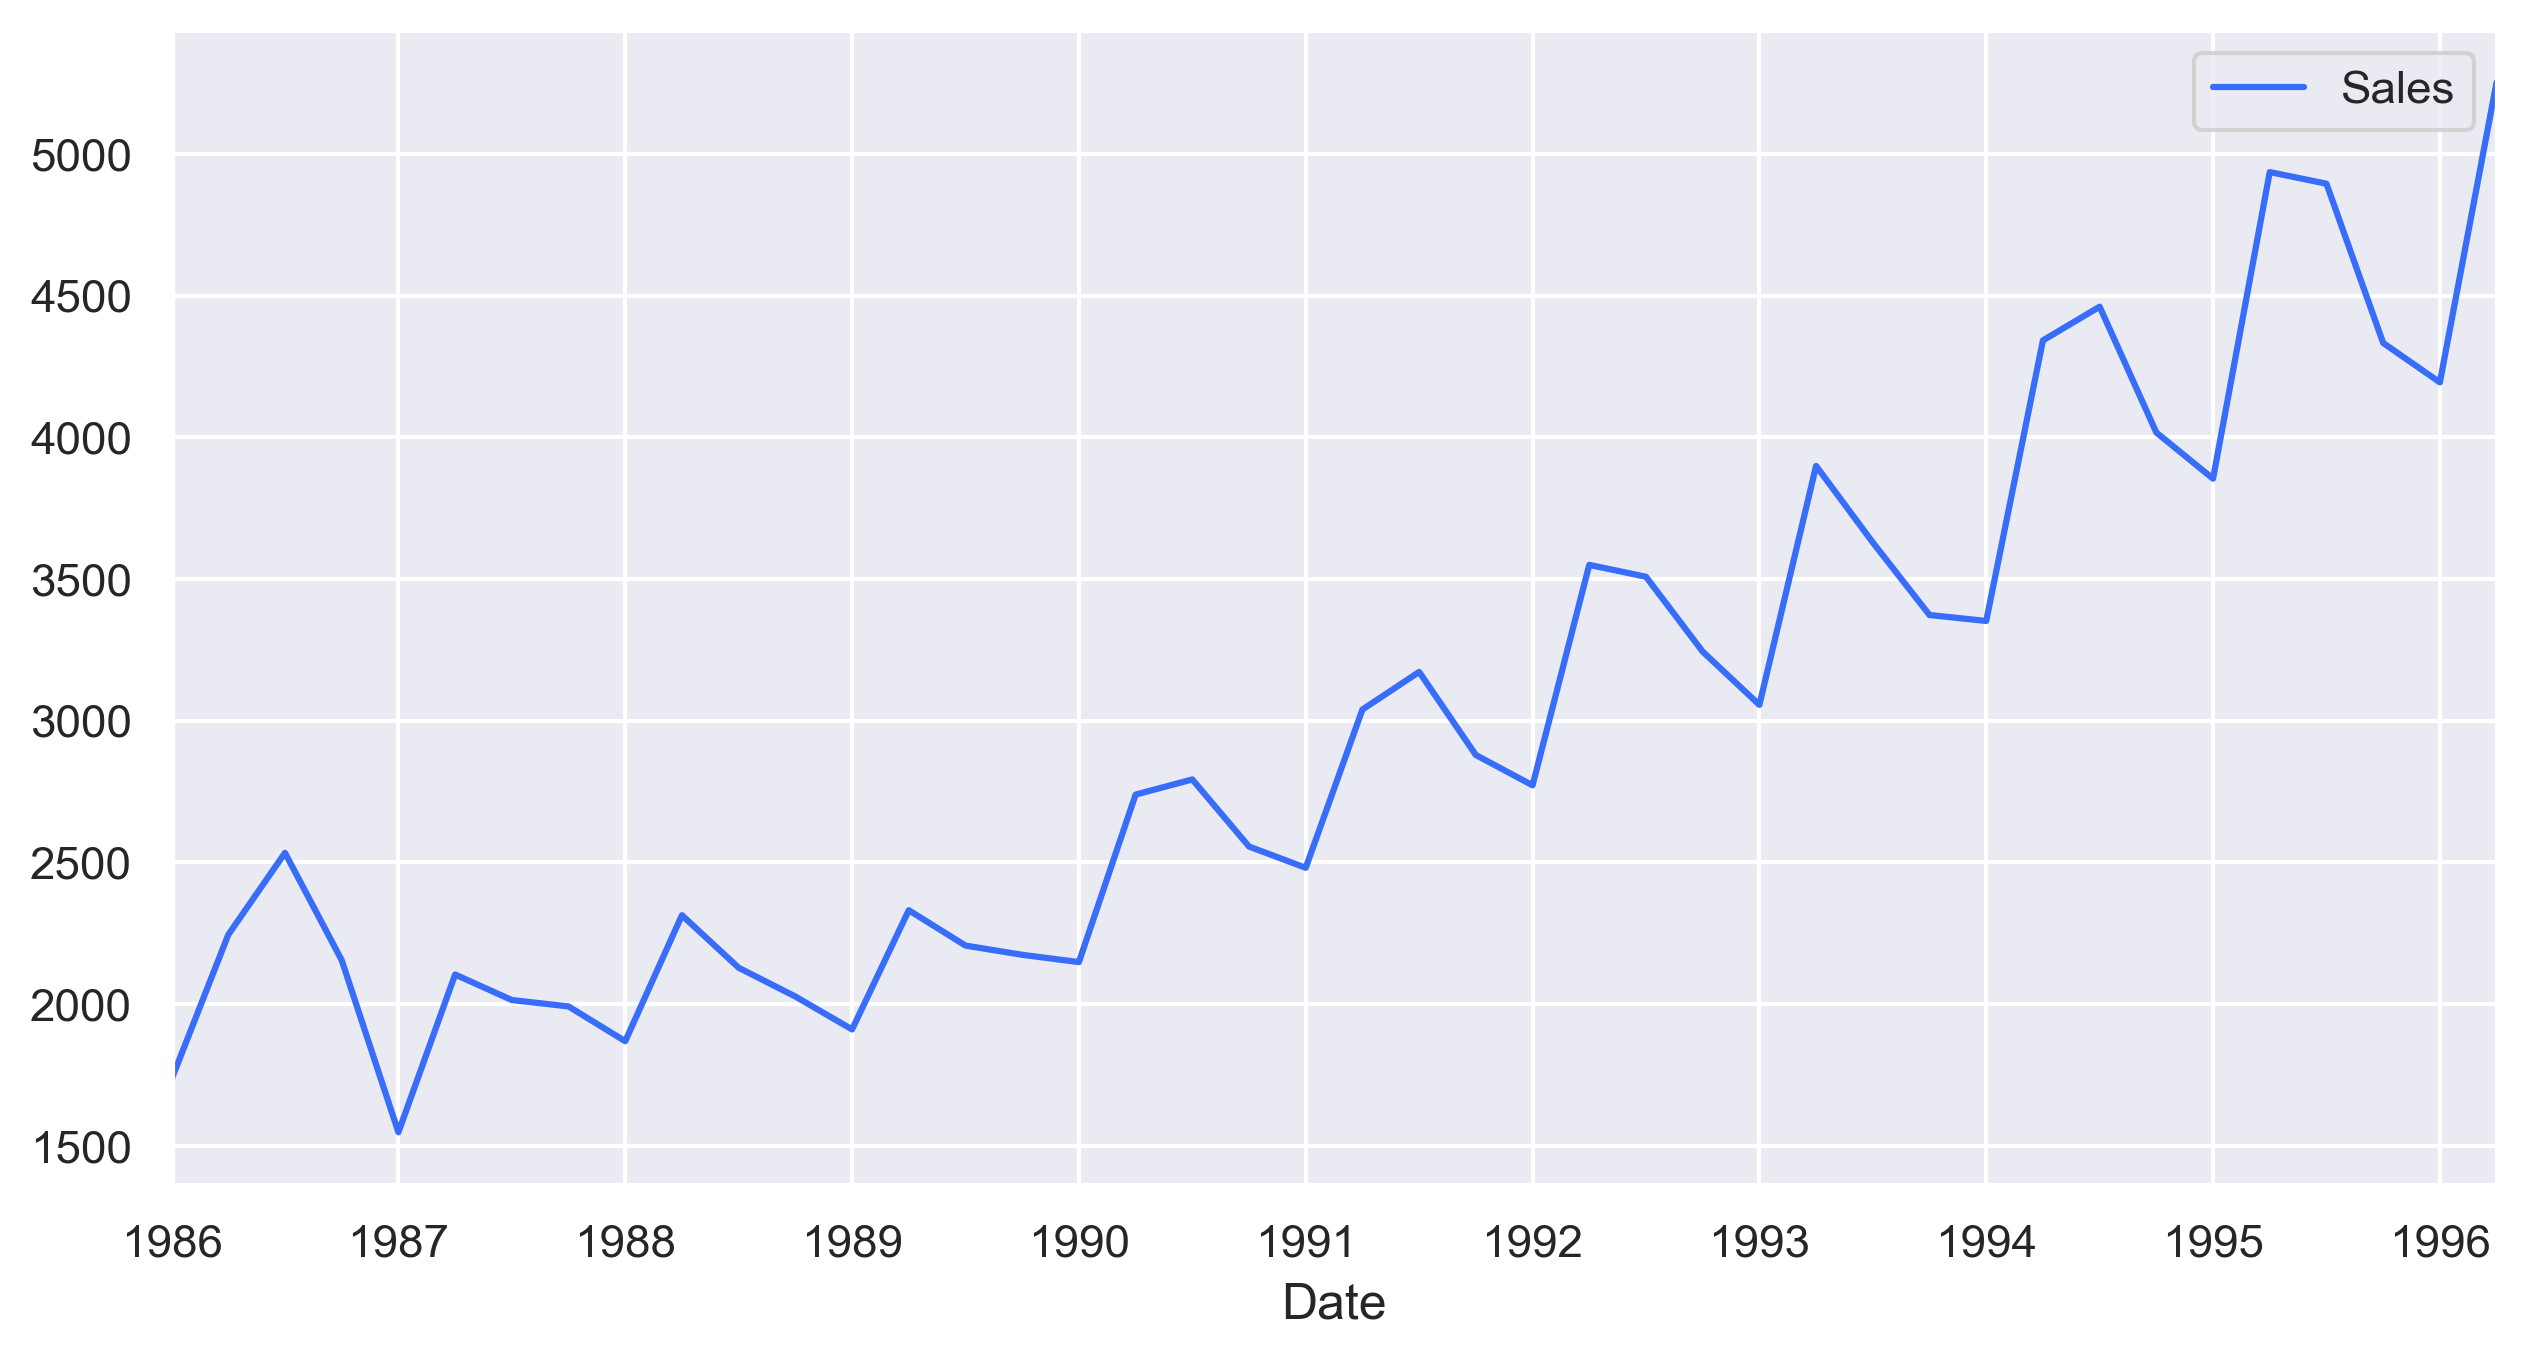

In [73]:
df.plot()

In [74]:
adfuller(df['Sales'])[1].round(5)

0.98692

In [ ]:
Null hypothesis: Data is Non stationary

Alternate Hypothesis: Data is Stationary

- If p< 0.05 ; Data is stationary

- if p>0.05; Data is not stationary

According the p-value, the dataset is non stationary as the p value is more than alpha value.

Arima model building.

- ARIMA is composed of 3 terms(Auto-Regression(p) + Integrated(d) + Moving-Average(q))
- First, we need to find out the order of arima model.

In [ ]:
#find out order of arima

In [75]:
order = auto_arima(df['Sales'])

In [76]:
order#(p,d,q)=>p=PACF,d=differencing method value,q=ACF,

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [77]:
df.shape

(124, 1)

In [78]:
#Split the data
train = df.head(112)
test = df.tail(12)

In [79]:
train.shape

(112, 1)

In [80]:
test.shape

(12, 1)

In [ ]:
#Arima model

In [82]:
model = ARIMA(train['Sales'], order=(2,1,2)).fit()

In [ ]:
# Evaluating the model

In [85]:
ypred = model.predict(start =112, end = 123)
ypred

1995-05-31    5118.734831
1995-06-30    5128.931689
1995-07-31    4991.192536
1995-08-31    4764.798756
1995-09-30    4522.777492
1995-10-31    4330.691952
1995-11-30    4230.728564
1995-12-31    4234.392548
1996-01-31    4324.356042
1996-02-29    4463.530917
1996-03-31    4607.859566
1996-04-30    4718.901720
Freq: M, Name: predicted_mean, dtype: float64

In [86]:
Arima_interpolated=np.sqrt(mean_squared_error(test['Sales'], ypred))
Arima_interpolated

203.5824494333734

In [87]:
#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","Arima","Arima_interpolated"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_add_sea,Arima,Arima_interpolated])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
7,Arima_interpolated,203.582449
6,Arima,473.033157
3,rmse_add_sea,1837.787972
4,rmse_add_sea_quad,1837.787972
2,rmse_Quad,1842.201311
0,rmse_linear,1857.004753
5,rmse_Mult_sea,4462.008204
1,rmse_Exp,4462.012768


In [88]:
#observation:Arima_interpolated model RMSE value is the best